In [66]:
import pandas as pd
import numpy as np

In [67]:
df = pd.read_csv("/content/car_insurance_fraud_dataset.csv")

In [68]:
df.shape

(30000, 24)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   policy_id                    30000 non-null  object 
 1   policy_state                 30000 non-null  object 
 2   policy_deductible            30000 non-null  int64  
 3   policy_annual_premium        30000 non-null  float64
 4   insured_age                  30000 non-null  int64  
 5   insured_sex                  30000 non-null  object 
 6   insured_education_level      30000 non-null  object 
 7   insured_occupation           30000 non-null  object 
 8   insured_hobbies              30000 non-null  object 
 9   incident_date                30000 non-null  object 
 10  incident_type                30000 non-null  object 
 11  collision_type               30000 non-null  object 
 12  incident_severity            30000 non-null  object 
 13  authorities_cont

In [70]:
# Logistic Regression

# The Flow:
# - loads the dataset
# - detects the binary target column
# - drop duplicates, handle missing values
# - safe handling of datetimes, simple date parts, frequency encode very high cardinality categoricals
# - preprocessing: impute, scale numerics, one-hot encode categoricals (SPARSE to be memory-safe)
# - model: LogisticRegression(class_weight='balanced')
# - evaluation
# - confusion Matrix, ROC curve, Precision Recall curve
# - explainability: top logistic coefficients
# - saves trained model to disk

In [71]:
# Imports & setup

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve
)


In [72]:
DATA_PATH = Path("/content/car_insurance_fraud_dataset.csv")

Loaded dataset: /content/car_insurance_fraud_dataset.csv
Shape: (30000, 24)

Columns & dtypes:
policy_id                       object
policy_state                    object
policy_deductible                int64
policy_annual_premium          float64
insured_age                      int64
insured_sex                     object
insured_education_level         object
insured_occupation              object
insured_hobbies                 object
incident_date                   object
incident_type                   object
collision_type                  object
incident_severity               object
authorities_contacted           object
incident_state                  object
incident_city                   object
incident_hour_of_the_day         int64
number_of_vehicles_involved      int64
bodily_injuries                  int64
witnesses                        int64
police_report_available         object
claim_amount                   float64
total_claim_amount             float64
fraud_re

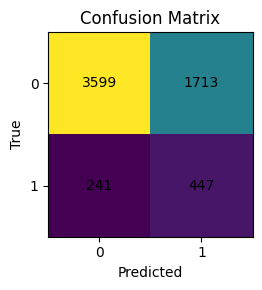

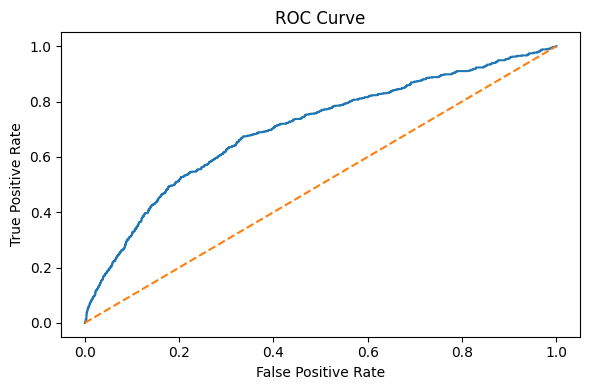

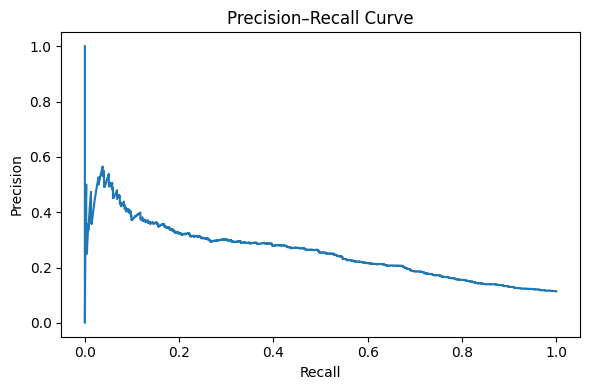


Top 10 features by |coefficient|:
                           feature      coef  abs_coef
0    authorities_contacted_Missing  0.823848  0.823848
1                     claim_amount  0.678443  0.678443
2               total_claim_amount -0.637541  0.637541
3     authorities_contacted_Police -0.356537  0.356537
4     incident_severity_Total Loss  0.340946  0.340946
5         insured_occupation_Sales  0.338097  0.338097
6                        witnesses -0.276691  0.276691
7       authorities_contacted_Fire -0.269455  0.269455
8  authorities_contacted_Ambulance -0.256787  0.256787
9         insured_occupation_Clerk  0.255956  0.255956

Next steps to consider:
1) Tune regularization strength C via GridSearchCV for better generalization
2) Try class balancing strategies (SMOTE, threshold tuning) to improve precision/recall trade-off
3) Consider tree-based baselines (RandomForest/XGBoost) for non-linear interactions
4) Add domain features (ratios, caps, logs of claim amounts, time since poli

In [73]:
# target detection
def detect_binary_target(df: pd.DataFrame) -> str:
    preferred_names = [
        "fraud", "is_fraud", "fraud_reported", "fraudulent",
        "isFraud", "label", "target", "class", "outcome"
    ]
    # preferred by name
    for name in preferred_names:
        for col in df.columns:
            if name.lower() in col.lower():
                # ensure it's binary-ish
                if df[col].dropna().nunique() <= 2:
                    return col

    # otherwise any binary column
    for col in df.columns[::-1]:
        if df[col].dropna().nunique() == 2:
            return col

    # fallback: last column
    return df.columns[-1]

# Load data
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
print("Loaded dataset:", DATA_PATH)
print("Shape:", df.shape)

# Basic info
print("\nColumns & dtypes:")
print(df.dtypes)

# Duplicates
dup_count = df.duplicated().sum()
print("\nDuplicate rows:", dup_count)
if dup_count > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print("Dropped duplicates. New shape:", df.shape)

# Detect & prepare target
target_col = detect_binary_target(df)
print("\nUsing target column:", target_col)
print("Raw target value counts:\n", df[target_col].value_counts(dropna=False))

y_raw = df[target_col].copy()
X = df.drop(columns=[target_col]).copy()

# Map target to 0/1 robustly
def map_target_to_binary(y: pd.Series) -> pd.Series:
    if y.dtype == "object" or y.dtype.name == "category":
        y_lower = y.dropna().astype(str).str.lower()
        uniq = set(y_lower.unique())

        # Common yes/no style labels
        if ({'yes','y','true','t','1'} & uniq) and ({'no','n','false','f','0'} & uniq):
            return y_lower.map(lambda v: 1 if v in {'yes','y','true','t','1','fraud'} else 0).fillna(0).astype(int)

        # If numeric like strings
        if y.dropna().apply(lambda x: str(x).isdigit()).all():
            return pd.to_numeric(y, errors="coerce").fillna(0).astype(int)

        # If exactly 2 unique values -> map first->0, second->1
        u = list(y.dropna().unique())
        if len(u) == 2:
            return y.map({u[0]:0, u[1]:1}).fillna(0).astype(int)

        # Fallback: treat anything non-zero/true-like as 1, else 0
        return y_lower.map(lambda v: 1 if v in {'yes','y','true','t','1','fraud'} else 0).fillna(0).astype(int)
    else:
        # Numeric types
        non_na = sorted(y.dropna().unique())
        if len(non_na) == 2 and not set(non_na).issubset({0,1}):
            a, b = non_na[:2]
            return y.apply(lambda z: 0 if z == a else 1).astype(int)
        return y.fillna(0).astype(int)

y = map_target_to_binary(y_raw)
print("\nTarget distribution (0/1):")
print(y.value_counts())

# Basic feature
n = len(X)
drop_cols = []
for col in X.columns:
    # Drop perfect-unique identifiers
    if X[col].nunique(dropna=False) == n:
        drop_cols.append(col)
    # Drop extremely high-cardinality object-ish IDs
    if X[col].dtype == "object" and X[col].nunique(dropna=False) > 0.8 * n:
        drop_cols.append(col)

if drop_cols:
    X = X.drop(columns=sorted(set(drop_cols)))
    print("\nDropped likely ID/high-cardinality columns:", sorted(set(drop_cols)))
    print("Shape after drop:", X.shape)

# Light feature engineering
# 1) Try converting object columns that look like datetimes; extract simple parts.
datetime_parts = ["year", "month", "day", "dayofweek"]
dt_cols_created = []
for col in X.columns:
    if X[col].dtype == "object":
        # Try parse (errors='coerce' turns failures to NaT)
        parsed = pd.to_datetime(X[col], errors="coerce", infer_datetime_format=True)
        if parsed.notna().sum() / len(parsed) > 0.5:  # >50% parsable -> treat as date
            X[col + "_year"] = parsed.dt.year
            X[col + "_month"] = parsed.dt.month
            X[col + "_day"] = parsed.dt.day
            X[col + "_dayofweek"] = parsed.dt.dayofweek
            dt_cols_created.extend([col + "_year", col + "_month", col + "_day", col + "_dayofweek"])
            # Keep original too (may be categorical like city names masquerading), we'll decide below

if dt_cols_created:
    print("\nExtracted datetime parts for columns (new):", dt_cols_created)

# 2) Numeric vs Categorical split
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Handle very-high-cardinality categoricals
# Frequency-encode any categorical column with >100 unique values to stay memory safe
ohe_cols = []
freq_cols = []
for col in categorical_cols:
    nunq = X[col].nunique(dropna=False)
    if nunq > 100:
        freq = X[col].value_counts(normalize=True)
        X[col + "_freq_enc"] = X[col].map(freq).fillna(0.0)
        freq_cols.append(col)
    else:
        ohe_cols.append(col)

# Extend numeric columns with frequency-encoded columns just created
numeric_cols_extended = sorted(set(numeric_cols + [c + "_freq_enc" for c in freq_cols]))

print("\nNumeric columns:", numeric_cols_extended)
print("One-hot columns (<=100 uniques):", ohe_cols)
print("Frequency-encoded columns (>100 uniques):", freq_cols)

# Sanity: ensure we still have features
if len(numeric_cols_extended) == 0 and len(ohe_cols) == 0:
    raise ValueError("No usable features left after preprocessing decisions.")

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True))
])

# Use SPARSE OneHot to avoid memory explosion
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")) # Removed sparse=True
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols_extended),
        ("cat", categorical_transformer, ohe_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3  # keep sparse if the output would be >30% sparse
)

# Model: Logistic Regression
logreg = LogisticRegression(
    class_weight="balanced",  # helpful for class imbalance
    solver="liblinear",       # stable for small/medium data & sparse features
    max_iter=1000,
    random_state=42
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", logreg)
])

# Fit
print("\nFitting Logistic Regression...")
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
try:
    y_proba = model.predict_proba(X_test)[:, 1]
except Exception:
    try:
        # decision function -> scale 0-1
        scores = model.decision_function(X_test)
        y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
    except Exception:
        y_proba = None

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_proba) if y_proba is not None else None

print("\nTest Metrics")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
if roc is not None:
    print(f"ROC AUC  : {roc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix (rows=true, cols=pred):\n", cm)

# Confusion Matrix, ROC, PR
def plot_confusion_matrix(cm):
    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks([0, 1], ["0", "1"])
    plt.yticks([0, 1], ["0", "1"])
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, str(z), ha='center', va='center')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm)

if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.tight_layout()
    plt.show()

    prec_vals, rec_vals, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(rec_vals, prec_vals)
    plt.title("Precision–Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.tight_layout()
    plt.show()

# Coefficients / Feature Importance

# Safely recover feature names (numeric + one-hot-expanded)
feature_names = []
try:
    pre = model.named_steps["preprocessor"]
    # numeric names
    feature_names.extend(list(numeric_cols_extended))
    # categorical one-hot names (if any)
    if ohe_cols:
        ohe = pre.named_transformers_["cat"].named_steps["onehot"]
        ohe_names = list(ohe.get_feature_names_out(ohe_cols))
        feature_names.extend(ohe_names)
except Exception:
    total = model.named_steps["classifier"].coef_.shape[1]
    feature_names = [f"feat_{i}" for i in range(total)]

coefs = model.named_steps["classifier"].coef_[0]
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False).reset_index(drop=True)

print("\nTop 10 features by |coefficient|:")
print(coef_df.head(10))

# Short guidance / next steps
print("\nNext steps to consider:")
print("1) Tune regularization strength C via GridSearchCV for better generalization")
print("2) Try class balancing strategies (SMOTE, threshold tuning) to improve precision/recall trade-off")
print("3) Consider tree-based baselines (RandomForest/XGBoost) for non-linear interactions")
print("4) Add domain features (ratios, caps, logs of claim amounts, time since policy start vs incident, etc)")